## Random Forests

In [2]:
import sklearn.datasets as datasets
import pandas as pd
import numpy as np
# import pydotplus

from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML

from lib import RandomForestHelper as RFH
from lib import RFGraph

%pylab inline
%config IPCompleter.greedy=True

Populating the interactive namespace from numpy and matplotlib


## Random forests
* Based on bagging decision trees
* Each tree is based on a bootstrapped sample
* The final classifier is the majority vote over the trees.
* **Unlike Bagging Trees:** Each split is chosen using random subset of the features.

<img alt="" src="figs/Random-Forest-Introduction.jpg" style="width:900px" />

### Main Parameters for a Random Forest:

* **n_estimators** - number of trees

* **max_features** - maximal number of features used when learning a split.

* **max_depth** - Maximal tree depth

For a full description of all parameters see [Reference](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

### Training and visualizing a small random forest

In [3]:
# We use "digits" the same dataset as the one used for decision trees.
D=datasets.load_digits()
D.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [4]:
#Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(D.data, D.target, test_size=0.5)

In [4]:
#training the random forest classifier
rf = RandomForestClassifier(max_depth=2, n_estimators=7)
rf = rf.fit(X_train,y_train)

Decision Tree 0 : 


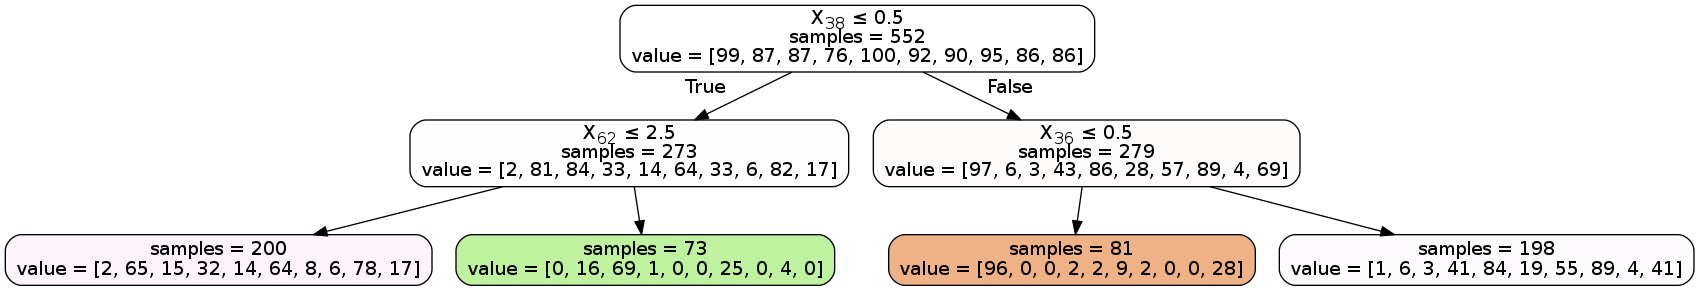

Decision Tree 1 : 


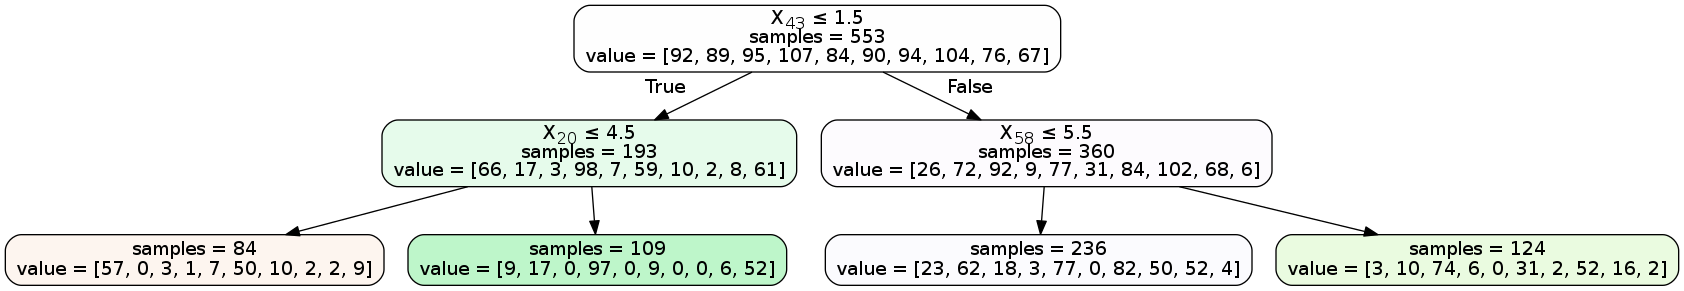

Decision Tree 2 : 


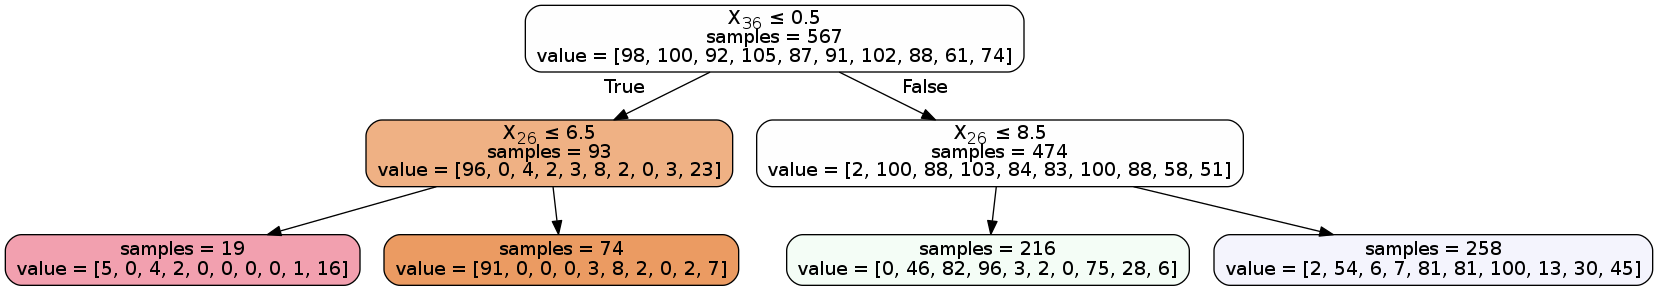

In [5]:
for i in range(3):
    RFGraph.generate_tree(rf, i) #ith Decision Tree: Where i is the Decision Tree number according to the above table)

## Predicting Category

1. For each sample, each tree gives a prediction.
2. The final prediction is the majority over the trees.
3. The vote counts contain additional useful information.

In [43]:
rf = RandomForestClassifier(max_depth=8, max_features=10, n_estimators=100)
rf = rf.fit(X_train,y_train)

### The errors
The prediction errors are summarized in the table below.

In [44]:
#define forward and backward indices for the comepeting three labels
labels=np.array([3,5,8])
rev_lookup = {labels[i]:i for i in range(3)}

pred,pred_category = RFH.predict_category(rf,X_test)  # pred contains, for each example, the prediction of each tree.

#filter out examples whose true label (y_test) is not in the set of 3 chosen labels
choose = y_test*0
for i in range(3):
    choose+=1*(y_test==labels[i])
pred_3=pred[choose>0,:]
y_test_3=np.array([rev_lookup[x] for x in y_test[choose>0]])

p=np.zeros([pred_3.shape[0],3]) # p is the number of votes given to each of the competing labels
for i in range(3):
    p[:,i]=np.sum(pred_3==labels[i],axis=1)

highest=np.argmax(p,axis=1) # the label among the 3 competing that got the largest number of votes (the plurality vote)

mistakes=highest != y_test_3 # Identifies the examples on which the plurality vote it incorrect

# print a table of the mistakes.
print('counter\t index\t [%3d %4d %4d ]   prediction true'%(labels[0],labels[1],labels[2]))
print('='*55)
j=0
for i in range(len(y_test_3)):
    if mistakes[i]:
        j+=1
        print(j,'\t',i,'\t [%3d %4d %4d ] \t'%(p[i,0],p[i,1],p[i,2]),labels[highest[i]],'\t',labels[y_test_3[i]])

counter	 index	 [  3    5    8 ]   prediction true
1 	 4 	 [  0   23   18 ] 	 5 	 8
2 	 68 	 [ 11   11   34 ] 	 8 	 3
3 	 74 	 [ 24   33    3 ] 	 5 	 3
4 	 151 	 [ 15    3   32 ] 	 8 	 3
5 	 153 	 [ 31   35    6 ] 	 5 	 3
6 	 160 	 [ 30    1   41 ] 	 8 	 3
7 	 171 	 [ 30    1   35 ] 	 8 	 3
8 	 181 	 [  6   32   22 ] 	 5 	 8
9 	 232 	 [ 15   25   20 ] 	 5 	 3
10 	 237 	 [  4   19   30 ] 	 8 	 5
11 	 253 	 [ 10   20   19 ] 	 5 	 8


In [39]:
p=p+np.abs(np.random.normal(0,0.01,size=p.shape)) # Dither points so that they don't fall on top of each other
Z=1/(np.sum(p,axis=1)+0.0001)  #normalize to sum to 1
p=(p.transpose()*Z).transpose()

### The prediction simplex
* Scores for **two** labels can be represented as a distribution over the line.
* Scores for **three** labels can be represented as points on a triangle.
* Scores for **four** or more labels are hard to visualize.

### Scatter plot on the triangular simplex

* Suppose that the number of votes we have for $[3,5,8]$ is $[6,1,3]$  
* This corresponds to the distribution vector $[0.6,0.1,0.3]$
* Which defines the location of the black circle.

<img alt="" src="figs/Convex-combination.png" style="width:500px" />

### Explanations of the figure
* The corners of the triangle represents 100% of the vote going to one class (number in square)
* Small dots represent correct label prediction
* Large dots represent mistakes.
* Black lines are the decision bundaries.
* Green lines indicate prediction margin.

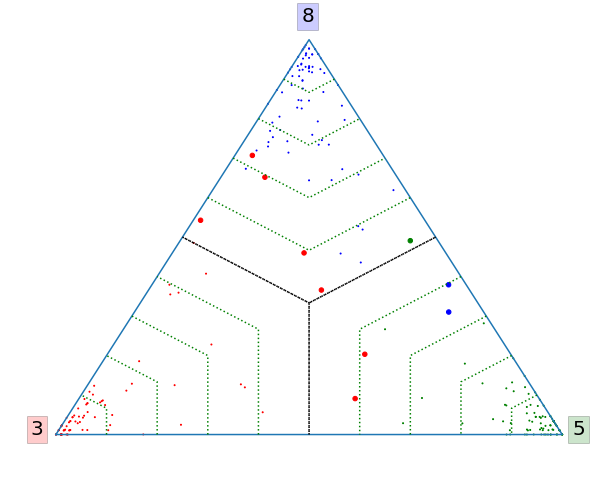

In [40]:
RFGraph.generate_simplex(p,y_test_3,mistakes,labels)

### Things to try

* What will happen if you abstrain in the region defined by the first green line? By the second green line?
* Random forests does not eliminate all of the variation in prediction. Try running the same code more than once and observe you get slightly different results each time.
* Random forests is less effective when the base classifier has low variance: try trees of depth 4
* Random forests is less effective if the number of trees is small try 5 trees of depth 8, then 20, 100, 200.

## Summary
* Random forests are very flxible, very fast to compute, and have low data variation.
* The distribution of the votes can be used 
  * To identify confusable labels.
  * To quantify prediction confidence.